<a href="https://www.kaggle.com/code/bensonduong/typography-generative-model-with-effects?scriptVersionId=100441915" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://colab.research.google.com/github/benduong2001/dsproject_font_decorator_bolditalic_unet/blob/main/font_bolditalic_unet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generative Image Model for Multiple, Controlled Effects** #
* This generative image model will have several effects that can be chosen to apply to the output image, depending on their parameterized weights
* In this case, the images are 20x20 gray-scale images of letters, and the effects are boldness and italicization. 
* Similar to Conditional GAN's, but will use encoder-decoder architecture with residuals, or U-net
* This dataset is from the UC Irvine Font Dataset https://archive.ics.uci.edu/ml/datasets/Character+Font+Images
* Also, check out this sister project: https://www.kaggle.com/code/bensonduong/font-type-image-classification?scriptVersionId=96862819

![](https://raw.githubusercontent.com/benduong2001/dsproject_font_decorator_bolditalic_unet/main/kaggle_intro_image.png)

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import pandas as pd
import os
from PIL import Image
from sklearn.preprocessing import normalize
import pickle
from tqdm import tqdm
plt.rcParams['figure.figsize'] = (7,7)

In [12]:
# example of training an conditional gan on the mnist dataset
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Concatenate

from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

In [13]:
# Load the Drive helper and mount
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
#PATH_FOLDER = "/content/drive/MyDrive/dsprojects/dsproject_imagery/dsprojects_fonts/"

## **1. Data Collection** ##

In [14]:
file_names = []
file_paths = []
file_names2 = []
file_paths2 = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    if dirname == "/kaggle/input/uci-fonts-dataset":
        for filename in filenames:
            filepath = (os.path.join(dirname, filename))
            file_paths.append(filepath)
            file_names.append(filename)
    if dirname == "/kaggle/input/font-unet-input-image-examples":
        for filename in filenames:
            filepath = (os.path.join(dirname, filename))
            file_paths2.append(filepath)
            file_names2.append(filename)

### **Data Collection - Characters to Include** ###
* This project will be like the last font project from before (linked at the first paragrap), and for now only capital letters will be used. This time however, the bold and/or italicized versions won't be excluded, since they are the target images.

In [15]:
# for each font's csv table, the column "m_label" denotes an identifier for a certain character
# the variables below are the m_labels for specific character groups (alphanumeric - uppercase, lowercase, digits)
MIN_M_LABEL = 33
MAX_M_LABEL = 126
m_labels_all = list(range(MIN_M_LABEL,MAX_M_LABEL+1))
m_labels_alphanum_alpha_upper = list(range(m_labels_all[32], m_labels_all[32+26]))
m_labels_alphanum_alpha_lower = list(range(m_labels_all[64], m_labels_all[64+26]))
m_labels_alphanum_num = list(range(m_labels_all[16], m_labels_all[16+10]))

# each row of the csv table has a 20x20 image for the character it represents, which can be made using a group of 400 columns. These column names are collected here for future use
pixel_column_names = []
for i in range(0, 20):
    for j in range(0, 20):
        pixel_column_name = "r{0}c{1}".format(str(i),str(j))
        pixel_column_names.append(pixel_column_name)

# for this, I'm going to just use the 26 capital letters to represent each font
# My main reason is that capital letters are arguably square-shaped and thus proportionally consistent in anatomy for most fonts.
# Because in this dataset, thin or wide characters get forcibly stretched or narrowed to fit a 20x20 space. 
# But you can change which characters you want to use below. 
CHOSEN_M_LABELS = []
CHOSEN_M_LABELS += m_labels_alphanum_alpha_upper
#CHOSEN_M_LABELS += m_labels_alphanum_alpha_lower
#CHOSEN_M_LABELS += m_labels_alphanum_num


CHARACTERS_AMOUNT = len(CHOSEN_M_LABELS)
# I'm going to iterate through each font file
#

In [16]:
ERROR_FONT_FAMILIES = ['BITSTREAMVERA','CREDITCARD', 'E13B', 'HANDPRINT', 'MONEY', 'NUMERICS', 'VIN']

### **Data Collection - Encoding Concatenation for Image Data** ###
* Encodings will be horizontal concatenations of binary arrays onto the train and test images, with the same dimenions
    * Italic is represened when the top half of the binary encoding array is full of 1's. 
    * Bold is represented when the bottom half is full of 1's
    * Bold AND italics combines both (in other words, an array full of 1's)
    * No effect is just a zero array
* To make concatenation compatible, the encoding array will be the same dimensions as the image array (20x20).
    * As long as bold vs italic encoding can still be differentiated at the lowest max-pooling level
* And the image array will be rescaled 0 to 1, not 0 to 255

In [17]:
def temp_create_channels(channel_type):
    # channel_type is 1 for italic, 2 for bold, 3 for both
    DIM1 = 20
    DIM2 = 20
    if channel_type == 0:
        return np.zeros((DIM1,DIM2))
    elif channel_type == 3:
        return temp_create_channels(1) + temp_create_channels(2)
    else:
        channel = np.zeros((DIM1,DIM2))
        ohe_divisions = 2
        span = DIM1//ohe_divisions

        span_idx = channel_type-1
        start = (span_idx*span)
        stop = (start+span)
        channel[(start):(stop),:] = 1
        return channel

### **Data Collection - Data Gathering and Train Test Splitting** ###
* Iteration of the UCI Font Dataset to gather the data
* Training and Testing will be 75 % to 25%

In [18]:
x_train = []
x_test = []
y_train = []
y_test = []
np.random.seed(1)
range_len_uci_font_family_csv_file_names = range(len(file_names))
range_len_uci_font_family_csv_file_names = tqdm(range_len_uci_font_family_csv_file_names)

for i in range_len_uci_font_family_csv_file_names:

    #if (((i+1)%25)==0): print(i+1, len(uci_font_family_csv_file_names));
    uci_font_family_csv_file_name = file_names[i]
    uci_font_family = uci_font_family_csv_file_name.split(".csv")[0]
    if uci_font_family in ERROR_FONT_FAMILIES:
        # skip these error font families
        continue
    uci_font_family_csv_file_path = file_paths[i]
    temp_uci_font_family_df_orig = pd.read_csv(uci_font_family_csv_file_path)
    # choose characters
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig[temp_uci_font_family_df_orig["m_label"].isin(CHOSEN_M_LABELS)]
    # sort for easiness (each of the m_label, whichever you chose, are now separated)
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig.sort_values(["m_label","strength",	"italic"])
    temp_uci_font_family_df_orig = temp_uci_font_family_df_orig.drop_duplicates(subset=["m_label","strength",	"italic"])
    
    # forloop for each character,
    # for each character, read and reshape the pixel columns, and design the concatenated channel(s) for italic, bold, and both
    # then fill the x_train, y_train, x_test, y_test lists, by choosing on the spot if it likes to be in either
    available_m_labels = temp_uci_font_family_df_orig["m_label"]

    temp_uci_font_family_df_orig[pixel_column_names] = temp_uci_font_family_df_orig[pixel_column_names].astype(float)
    temp_uci_font_family_df_orig[pixel_column_names] /= 255

    assert temp_uci_font_family_df_orig.shape[0] == 26*4

    for m_label_idx in range(len(available_m_labels)):
        # iterate through the m_labels of the font, which will include regular form, and bold/italic forms
        temp_m_label = available_m_labels.values[m_label_idx]
        temp_m_label_df = temp_uci_font_family_df_orig[temp_uci_font_family_df_orig["m_label"] == temp_m_label]
        # this should be up to 4 rows
        assert temp_m_label_df.shape[0] == 4

        temp_m_label_df_pixels = temp_m_label_df[pixel_column_names].values.reshape((4,20,20))

        regular_form_arr = temp_m_label_df_pixels[0]
        italic_form_arr = temp_m_label_df_pixels[1]
        bold_form_arr = temp_m_label_df_pixels[2]
        bold_italic_form_arr = temp_m_label_df_pixels[3]

        # now dealing with the concatenation process. this is difficult
        temp_target_form_arr_list = [regular_form_arr,italic_form_arr,bold_form_arr,bold_italic_form_arr]
        for channel_type_idx in range(len(temp_target_form_arr_list)):
            temp_target_form_arr = temp_target_form_arr_list[channel_type_idx]
            # channel_type is 1 for italic, 2 for bold, 3 for both,0 for reg
            channel_type = channel_type_idx #+ 1 # don't change

            temp_channel = temp_create_channels(channel_type)

            # reshape so that it is now (20, 20, 1 + # of channels)
            temp_regular_form_concat = np.hstack([regular_form_arr,temp_channel])
            temp_regular_form = np.expand_dims(temp_regular_form_concat,2)

            temp_target_form_concat = np.hstack([temp_target_form_arr,temp_channel])
            # change target image from 2d array to 1-channel 3d array
            temp_target_form = np.expand_dims(temp_target_form_concat,2)
            
            # decide if train or test:
            train_test_decider = np.random.choice([1,0],size=1, p=[0.75, 0.25])[0]
            if train_test_decider:
                x_train.append(temp_regular_form)
                y_train.append(temp_target_form)
            else:
                x_test.append(temp_regular_form)
                y_test.append(temp_target_form)

100%|██████████| 153/153 [01:16<00:00,  2.00it/s]


In [19]:
x_train = np.array(x_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
x_test = np.array(x_test).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

np.random.seed(1)
randomize = np.arange(len(x_train))
np.random.shuffle(randomize)
x_train_ = x_train[randomize]
y_train_ = y_train[randomize]

## **2. Modelling and Evaluation** ##

* The creation and architecture for the generative model
* The UNet Architecture will be used (loosely summarized, it's Encoder-Decoder but with "bridging" residuals)
* Before/After each downstream/upstream layer, a series of convolutions will be done
    * (repreented by Conv_Dim_Preserve), it maintains the same dimensions throughout by using same-padding and no strides


In [20]:
def Conv_Dim_Preserved(x, n_filters):
    # preserve dimensiond: keep padding same, no stride
    # 1st round of conv
    x = Conv2D(filters = n_filters, 
               kernel_size = (3, 3),
               kernel_initializer = 'he_normal', 
               padding = 'same')(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    # 2nd round of conv
    x = Conv2D(filters = n_filters, 
               kernel_size = (3, 3),
               kernel_initializer = 'he_normal', 
               padding = 'same')(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    return x

N_FILTERS = 32

inputs = Input((20, 40, 1))
x = inputs

# 20 by 20

c1 = Conv_Dim_Preserved(x, N_FILTERS*1)
print(c1.shape)
p1 = MaxPooling2D((2, 2), padding="same")(c1) # reduce dimensionality

# 10 by 10

c2 = Conv_Dim_Preserved(p1, N_FILTERS*2)
print(c2.shape)
p2 = MaxPooling2D((2, 2), padding="same")(c2) # reduce dimensionality

# 5 by 5

# Bottom of the unet "valley"
c3 = Conv_Dim_Preserved(p2, N_FILTERS*4)
# climb back up

u4 = Conv2DTranspose(N_FILTERS*2, (3, 3), strides = (2, 2), padding = 'same')(c3)
print(u4.shape, c2.shape)
u4 = Concatenate()([u4, c2])
u4 = Dropout(0.1)(u4)
c4 = Conv_Dim_Preserved(u4, N_FILTERS*2)
# 10 x 10

u5 = Conv2DTranspose(N_FILTERS*1, (3, 3), strides = (2, 2), padding = 'same')(u4)
print(u5.shape, c1.shape)
u5 = Concatenate()([u5, c1])
u5 = Dropout(0.1)(u5)
c5 = Conv_Dim_Preserved(u5, N_FILTERS*1)
# 10 x 10

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5) # CHANNEL IS 1
unet_model = Model(inputs=[inputs], outputs=[outputs])

unet_model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

unet_model.summary()

2022-07-09 23:14:43.201328: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


(None, 20, 40, 32)
(None, 10, 20, 64)
(None, 10, 20, 64) (None, 10, 20, 64)
(None, 20, 40, 32) (None, 20, 40, 32)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 40, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 20, 40, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 20, 40, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 20, 40, 32)   128         activation[0][

In [21]:
history = unet_model.fit(x_train_, y_train_,epochs=2, batch_size=20)

2022-07-09 23:14:47.218036: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3
2279/2279 [==============================] - 214s 93ms/step - loss: 0.1325 - accuracy: 0.6121
Epoch 2/3
2279/2279 [==============================] - 212s 93ms/step - loss: 0.1096 - accuracy: 0.6153
Epoch 3/3
2279/2279 [==============================] - 222s 97ms/step - loss: 0.1031 - accuracy: 0.6160


In [22]:
output_data = unet_model.predict(x_test, batch_size=512)

## **Modelling and Evaluation - Evaluating Test Dataset** ##
* This section will look through random examples of the test dataset
* The original input image, then the model generation, then the actual target image, will be shown. 
* For display purposes, the encoding portion of the array will be hidden.

In [23]:
def show_test_images(test_idx):
    # shows the images for the test set, with the x image, prediction image, and actual y image,
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 30))
    temp_x_test_img = np.squeeze((x_test[test_idx]*255).astype(int))
    temp_y_test_img = np.squeeze((y_test[test_idx]*255).astype(int))
    temp_pred_img = np.squeeze((output_data[test_idx]*255).astype(int))

    MAX_PIXEL_SHADE = 255
    if temp_x_test_img[:,20:].mean() == MAX_PIXEL_SHADE:
        effect = "Bold & Italic"
    elif temp_x_test_img[:,20:].mean() == 0:
        effect = "No Effect"
    else:
        if temp_x_test_img[:10,20:].mean() == MAX_PIXEL_SHADE:
            effect = "Italic"
        else:
            effect = "Bold"

    axes[0].imshow(MAX_PIXEL_SHADE-temp_x_test_img[:,:20], cmap="gray")
    axes[0].set_title("Input Image")
    axes[2].imshow(MAX_PIXEL_SHADE-temp_pred_img[:,:20], cmap="gray")
    axes[2].set_title("Model's Generated Output Image")
    axes[1].imshow(MAX_PIXEL_SHADE-temp_y_test_img[:,:20], cmap="gray")
    axes[1].set_title("Target Output Image\n Effect: {0}".format(effect))
    return axes


array([<AxesSubplot:title={'center':'Input Image'}>,
       <AxesSubplot:title={'center':'Target Output Image\n Effect: Italic'}>,
       <AxesSubplot:title={'center':"Model's Generated Output Image"}>],
      dtype=object)

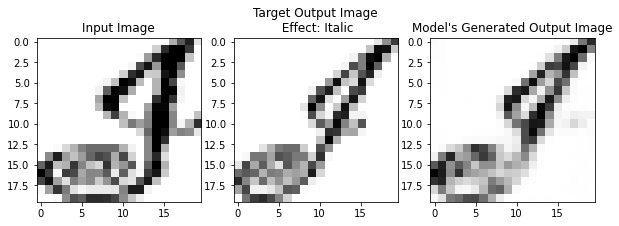

In [180]:
show_test_images(1781)

array([<AxesSubplot:title={'center':'Input Image'}>,
       <AxesSubplot:title={'center':'Target Output Image\n Effect: Bold'}>,
       <AxesSubplot:title={'center':"Model's Generated Output Image"}>],
      dtype=object)

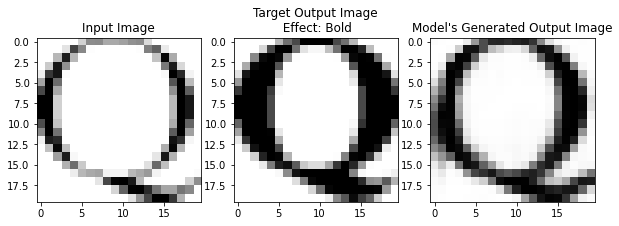

In [25]:
### show_test_images(6898)
show_test_images(602)

array([<AxesSubplot:title={'center':'Input Image'}>,
       <AxesSubplot:title={'center':'Target Output Image\n Effect: Italic'}>,
       <AxesSubplot:title={'center':"Model's Generated Output Image"}>],
      dtype=object)

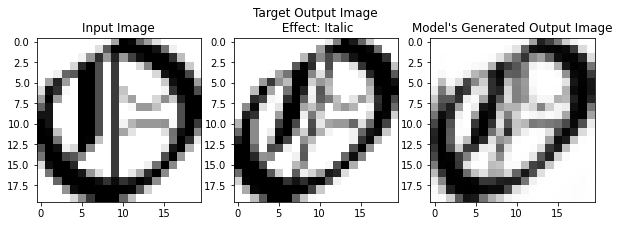

In [181]:
show_test_images(8300)
#show_test_images(7301)

array([<AxesSubplot:title={'center':'Input Image'}>,
       <AxesSubplot:title={'center':'Target Output Image\n Effect: Bold & Italic'}>,
       <AxesSubplot:title={'center':"Model's Generated Output Image"}>],
      dtype=object)

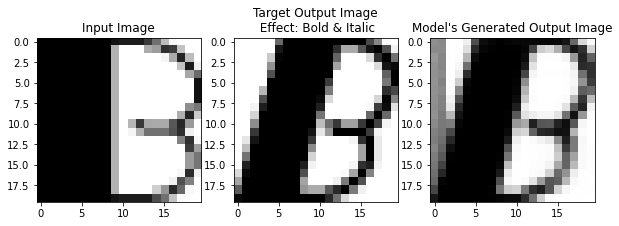

In [27]:
show_test_images(121)

array([<AxesSubplot:title={'center':'Input Image'}>,
       <AxesSubplot:title={'center':'Target Output Image\n Effect: Bold'}>,
       <AxesSubplot:title={'center':"Model's Generated Output Image"}>],
      dtype=object)

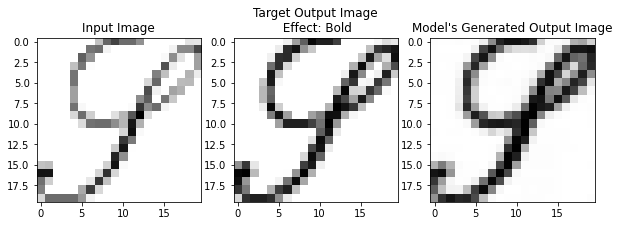

In [28]:
show_test_images(7704)

array([<AxesSubplot:title={'center':'Input Image'}>,
       <AxesSubplot:title={'center':'Target Output Image\n Effect: Italic'}>,
       <AxesSubplot:title={'center':"Model's Generated Output Image"}>],
      dtype=object)

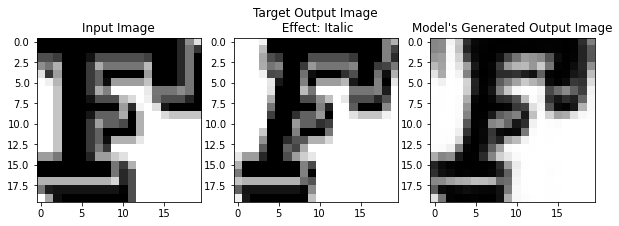

In [29]:
show_test_images(6904)

array([<AxesSubplot:title={'center':'Input Image'}>,
       <AxesSubplot:title={'center':'Target Output Image\n Effect: Bold & Italic'}>,
       <AxesSubplot:title={'center':"Model's Generated Output Image"}>],
      dtype=object)

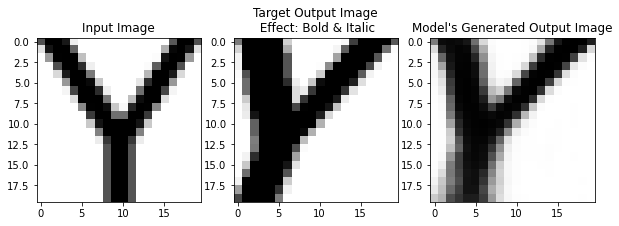

In [182]:
#show_test_images(4600)
show_test_images(4701)

In [111]:
unet_model.save("model_font_bolditalic_v2.h5")
saved_unet_model = tf.keras.models.load_model("model_font_bolditalic_v2.h5")

## **3. User's Input** ##

* Now, you can create your own
* Include the input image. It must be a 20x20 picture with a handdrawn white character on a black background
* Specify the character styling: bold, italic, both, neither
    * These can be done by adjusting the italic and bold arguments(between 0 and 1). These 2 options don't need to sum up to 1
    * For example, see what a 40% italic, 90% bold image would look like

In [31]:
def create_encoding(italic, bold):
    # channel_type is 1 for italic, 2 for bold, 3 for both
    assert italic >= 0 and italic <= 1
    assert bold >= 0 and bold <= 1

    DIM1 = 20
    DIM2 = 20
    channel = np.zeros((DIM1,DIM2)).astype(float)
    channel[:10,:] = italic
    channel[10:,:] = bold

    return channel

In [55]:
def show_generation_input(input_image, ITALIC,BOLD):
    # Image Pre-processing

    input_image_arr = np.array(input_image)
    input_image_arr = input_image_arr.astype(float)
    #MAX_PIXEL_SHADE = 255
    MAX_PIXEL_SHADE = input_image_arr.max()
    input_image_arr /= MAX_PIXEL_SHADE

    # Effect Encoding

    temp_encoding = create_encoding(ITALIC,BOLD).astype(float)
    input_image_arr_concat = np.hstack([input_image_arr,temp_encoding])
    # plt.imshow((input_image_arr_concat*255).astype(int))

    # Effect Generation

    model_input_image = np.array([np.expand_dims(input_image_arr_concat,2)]) # model_input_image.shape # x_test.shape
    output_generation = unet_model.predict(model_input_image)

    output_generation_image_array = np.squeeze((output_generation[0]*255).astype(int))

    output_generation_image = output_generation_image_array[:, :20]

    # shows the images for the test set, with the x image, prediction image
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

    axes[0].imshow(1-input_image_arr,cmap="gray")
    axes[0].set_title("Input Image")
    axes[1].imshow(255-output_generation_image,cmap="gray")
    axes[1].set_title("Model's Generated Output Image\nItalic={0}%, Bold={1}%".format(str(int(ITALIC*100)),str(int(BOLD*100))))

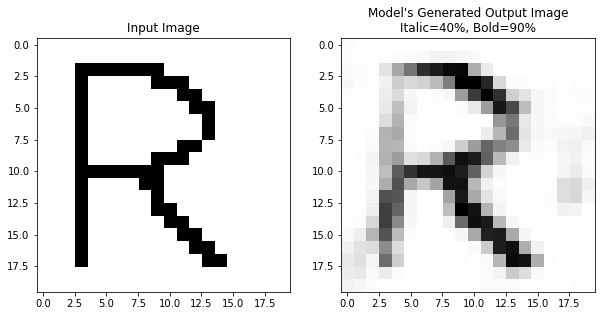

In [74]:
INPUT_IMAGE_FILE_NAME = file_paths2[2] # must be 20x20 png, white text on black background
input_image = Image.open(INPUT_IMAGE_FILE_NAME)
ITALIC_OPTION = 0.4
BOLD_OPTION = 0.9
show_generation_input(input_image, ITALIC=ITALIC_OPTION, BOLD=BOLD_OPTION)

#### **We can try out more options** ####

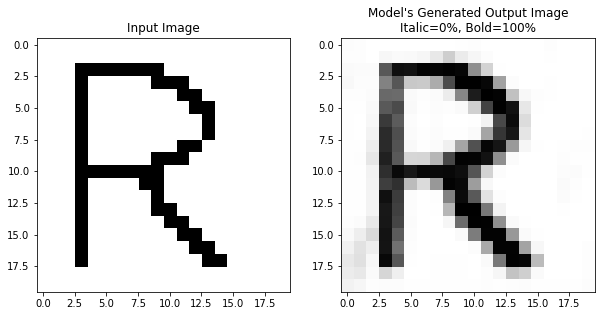

In [57]:
show_generation_input(input_image, ITALIC=0, BOLD=1)

#### **The model seems to respond differently based on font-type** ####
* In typography, when a serif font gets bolded, usually every part of the letter gets thickened **except** the serif-parts.
* This input example is a hand-drawn serif letter R
* It seems like the model has in fact picked up on this typographic convention (aside from recognizing the font-type of the letter). Compare it with the bold san serif R previously. More inspection will be needed to look into this.

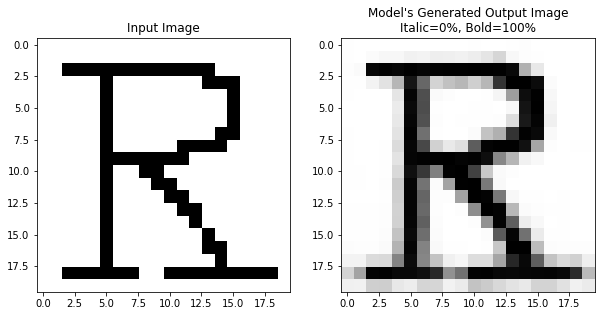

In [76]:
INPUT_IMAGE_FILE_NAME = file_paths2[1] # must be 20x20 png, white text on black background
input_image = Image.open(INPUT_IMAGE_FILE_NAME)
ITALIC_OPTION = 0
BOLD_OPTION = 1
show_generation_input(input_image, ITALIC=ITALIC_OPTION, BOLD=BOLD_OPTION)

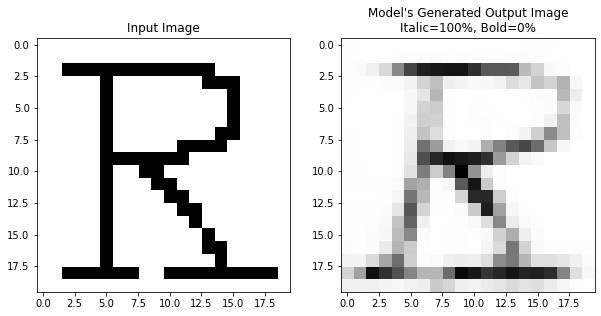

In [77]:
show_generation_input(input_image, ITALIC=1, BOLD=0)

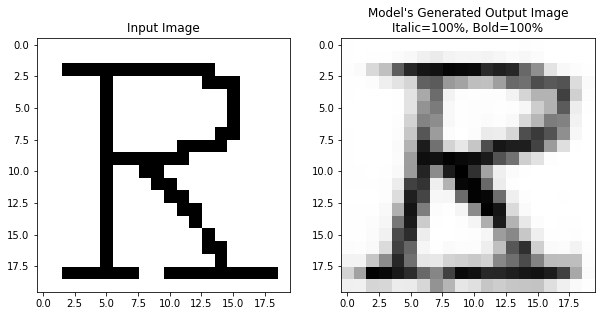

In [78]:
show_generation_input(input_image, ITALIC=1, BOLD=1)

#### **How will it work with a smiley face?** ####
* The dataset only has the capital letters. How will it respond to a number, a lowercase letter, a question mark, or even a smiley face?

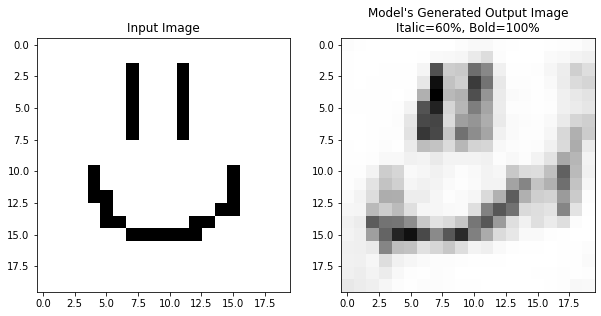

In [71]:
INPUT_IMAGE_FILE_NAME = file_paths2[0] # must be 20x20 png, white text on black background
input_image = Image.open(INPUT_IMAGE_FILE_NAME)
ITALIC_OPTION = 0.6
BOLD_OPTION = 1
show_generation_input(input_image, ITALIC=ITALIC_OPTION, BOLD=BOLD_OPTION)